# Regrid LME mask to model grid

In [1]:
import os
import numpy as np
import xarray as xr
import xesmf as xe
import pop_tools

## Input parameters

In [2]:
dst_grid = 'POP_gx1v6'
src_file_in = 'data/esm26_lme_mask_onedeg.nc'
varname = 'lme_mask'

dst_file_out = f'data/LME-mask-{dst_grid}.nc'

## Read the source data

In [3]:
def fix_and_prep_ds(ds):
    """
    make the varnames as xesmf likes them
    correct mask dtype to int   
    """
    from netCDF4 import default_fillvals
    
    # rename vars
    ds = ds.rename({'Lat': 'lat', 'Lon': 'lon'}).set_coords(['lat', 'lon'])    

    #return ds
    # change type
    fv = default_fillvals['i4']
    data = ds[varname].fillna(fv)    
    
    encoding = ds[varname].encoding
    encoding['_FillValue'] = fv
    encoding['dtype'] = np.int32
    ds[varname].data = data.astype(np.int32)
    
    ds[varname] = ds[varname].where(ds[varname] != fv)
    ds[varname] = ds[varname].transpose('y', 'x')
    
    ds[varname].encoding = encoding
    return ds

src_data = xr.open_dataset(src_file_in)
src_data = fix_and_prep_ds(src_data)

src_data.info()

xarray.Dataset {
dimensions:
	x = 360 ;
	y = 180 ;

variables:
	float64 lat(x, y) ;
		lat:long_name = mask latitude ;
		lat:standard_name = lat ;
		lat:axis = Y ;
	float64 lon(x, y) ;
		lon:long_name = mask longitude ;
		lon:standard_name = lon ;
		lon:axis = X ;
	float64 lme_mask(y, x) ;
		lme_mask:long_name = LME mask ;

// global attributes:
	:creation_date = 14-May-2021 13:35:42 ;
	:_FillValue = 1e+20 ;
}

### Make a quick plot


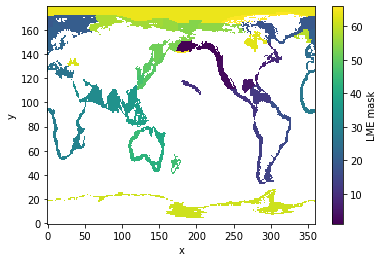

In [4]:
src_data[varname].plot()

## Read the destination grid

In [5]:
dst_data = pop_tools.get_grid(dst_grid)[['TLAT', 'TLONG', 'KMT', 'TAREA']]
dst_data = dst_data.rename({'TLAT': 'lat', 'TLONG': 'lon'})

dst_data.info()

/glade/work/mclong/miniconda3/envs/fish-offline/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 lat(nlat, nlon) ;
		lat:units = degrees_north ;
		lat:long_name = T-grid latitude ;
	float64 lon(nlat, nlon) ;
		lon:units = degrees_east ;
		lon:long_name = T-grid longitude ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;

// global attributes:
	:lateral_dims = [384, 320] ;
	:vertical_dims = 60 ;
	:vert_grid_file = gx1v7_vert_grid ;
	:horiz_grid_fname = inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8 ;
	:topography_fname = inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4 ;
	:region_mask_fname = inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4 ;
	:type = dipole ;
	:title = POP_gx1v6 grid ;
}

## Perform regridding

In [6]:
regridder = xe.Regridder(src_data, dst_data, 'nearest_s2d')
ds_out = regridder(src_data).rename({'lat': 'TLAT', 'lon': 'TLONG'})
ds_out[varname].attrs = src_data[varname].attrs
ds_out[varname].encoding = src_data[varname].encoding
for v in ['KMT', 'TAREA']:
    ds_out[v] = dst_data[v]
ds_out.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 lme_mask(nlat, nlon) ;
		lme_mask:long_name = LME mask ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;

// global attributes:
	:regrid_method = nearest_s2d ;
}

/glade/work/mclong/miniconda3/envs/fish-offline/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


### Check output plot

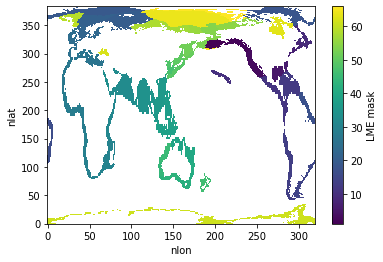

In [7]:
ds_out[varname].plot()

## Write output file

In [8]:
ds_out.to_netcdf(dst_file_out)

# use ncdump via os to ensure all looks good
os.environ['dst_file_out'] = dst_file_out
!ncdump -h $dst_file_out

netcdf LME-mask-POP_gx1v6 {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
variables:
	int lme_mask(nlat, nlon) ;
		lme_mask:_FillValue = -2147483647 ;
		lme_mask:long_name = "LME mask" ;
		lme_mask:coordinates = "TLAT TLONG" ;
	double TLONG(nlat, nlon) ;
		TLONG:_FillValue = NaN ;
		TLONG:units = "degrees_east" ;
		TLONG:long_name = "T-grid longitude" ;
	double TLAT(nlat, nlon) ;
		TLAT:_FillValue = NaN ;
		TLAT:units = "degrees_north" ;
		TLAT:long_name = "T-grid latitude" ;
	int KMT(nlat, nlon) ;
		KMT:long_name = "k Index of Deepest Grid Cell on T Grid" ;
		KMT:coordinates = "TLAT TLONG" ;
	double TAREA(nlat, nlon) ;
		TAREA:_FillValue = NaN ;
		TAREA:units = "cm^2" ;
		TAREA:long_name = "area of T cells" ;
		TAREA:coordinates = "TLAT TLONG" ;

// global attributes:
		:regrid_method = "nearest_s2d" ;
}


### Confirm that data can be read in correctly by `xarray`

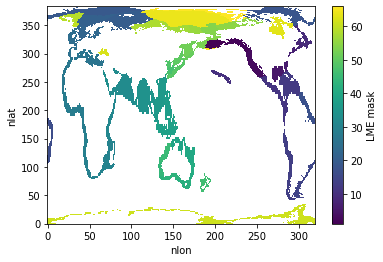

In [9]:
with xr.open_dataset(dst_file_out) as ds:
    ds[varname].plot()